In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
!cd data/COVID-19/; git pull

remote: Enumerating objects: 709, done.
remote: Counting objects: 100% (709/709), done.
remote: Total 2381 (delta 709), reused 709 (delta 709), pack-reused 1672
Receiving objects: 100% (2381/2381), 6.51 MiB | 1.99 MiB/s, done.
Resolving deltas: 100% (1129/1129), completed with 21 local objects.
From https://github.com/CSSEGISandData/COVID-19
   e69d4ce..4b81417  master     -> origin/master
   53093e4..bdf046e  web-data   -> origin/web-data
Updating e69d4ce..4b81417
Fast-forward
 .../csse_covid_19_daily_reports/03-11-2020.csv     | 217 ++++++
 .../csse_covid_19_daily_reports/03-12-2020.csv     | 219 ++++++
 .../time_series_19-covid-Confirmed.csv             | 755 +++++++++++----------
 .../time_series_19-covid-Deaths.csv                | 755 +++++++++++----------
 .../time_series_19-covid-Recovered.csv             | 755 +++++++++++----------
 .../20200304-sitrep-44-covid-19.pdf                | Bin 0 -> 969597 bytes
 .../20200305-sitrep-45-covid-19.pdf                | Bin 0 -> 682952 b

In [4]:
df = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [5]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,47,48,50,50,50,53,59,70
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,293,331,360,420,461,502,511,581,639,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,110,117,130,138,150,150,160,178,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,36,50,50,83,93,99,117,129,149,149


In [6]:
X = df[ df["Country/Region"] == "Germany" ]
del X["Province/State"]
del X["Country/Region"]
del X["Lat"]
del X["Long"]
X = X.T
X.index = pd.to_datetime( X.index )
Cases = X.iloc[:,0]
Cases.index = [ t.timestamp() for t in pd.to_datetime( Cases.index ) ]

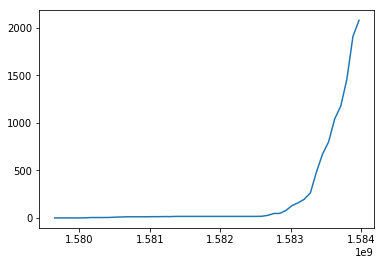

In [7]:
Cases.plot()

In [8]:
x_data = np.array( [ Cases.index ] ).T # shape ( #samples, #features = 1 )
y_data = np.array( [ Cases ] ).T       # shape ( #samples, #targets = 1 )

In [9]:
print(x_data.shape)
print(y_data.shape)

(51, 1)
(51, 1)


# Linear Regression

In [10]:
def ts(y, m, d):
    return datetime(y,m,d).timestamp()

In [11]:
from sklearn import linear_model

from datetime import datetime
from matplotlib import pyplot as plt

In [12]:
lreg = linear_model.LinearRegression().fit(x_data, y_data)

In [13]:
Xpred = np.array( [ np.linspace( ts(2020,2,1), ts(2020,3,10), 100 ) ] ).T
Ypred = lreg.predict(Xpred)

R2 =  0.407802298247


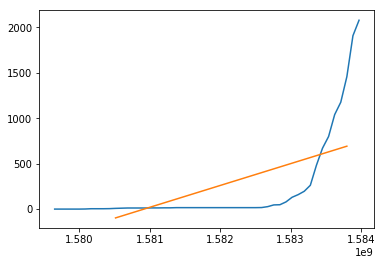

In [14]:
plt.plot(x_data, y_data)
plt.plot(Xpred, Ypred)
print("R2 = ", lreg.score(x_data, y_data))

# Log Linear Model

In [15]:
N = 30 # ignore the first N entries
# TODO: Use sample_weight vector instead
xl_data = x_data[N:]
yl_data = np.log(y_data[N:])

In [16]:
lreg = linear_model.LinearRegression().fit(xl_data, yl_data)

In [17]:
Xl_pred = np.array( [ np.linspace( ts(2020,2,1), ts(2020,4,1), 200 ) ] ).T
Yl_pred = np.exp( lreg.predict(Xl_pred) )

(0, 3000)

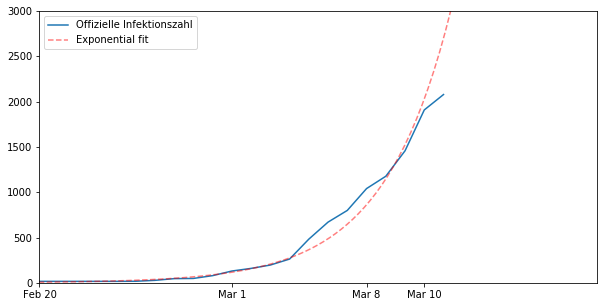

In [18]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data)
plt.plot(Xl_pred, Yl_pred, "--", color="red", alpha=0.5)
plt.xticks([ ts(2020,2,20), ts(2020,3,1), ts(2020,3,8), ts(2020,3,11) ],
           ["Feb 20", "Mar 1", "Mar 8", "Mar 10"])
plt.legend([ "Offizielle Infektionszahl", "Exponential fit" ])
plt.xlim( ts(2020,2,20), ts(2020,3,20) )
plt.ylim( 0, 3000 )

# Exponential Model

- This is not a linear regression
- Use Scipy minimize to minimize loos function:
  - Allows to control error weigth
  - Full flexibility in changing the model

In [19]:
from scipy.optimize import minimize

In [20]:
x0 = ts(2020,2,1)
def f(x, a, b):
    return np.exp( a + b * (x - x0)/86400 )

def Loss(X, Y, f, p):
    return np.mean( np.abs( f(X, *p) - Y ) ** 2 / 1000 ) # + 1e9 * (p[0]**2 + p[1]**2)

In [21]:
p0 = [ 2, 0.1 ]
M = minimize(lambda p: Loss(x_data, y_data, f, p), p0)
print(M)

      fun: 2.446991013709817
 hess_inv: array([[  4.80115460e-01,  -1.25123399e-02],
       [ -1.25123399e-02,   3.27335125e-04]])
      jac: array([ -5.96046448e-08,   1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 9
     njev: 17
   status: 0
  success: True
        x: array([-1.22204049,  0.22338997])


In [22]:
X_pred = np.linspace( ts(2020,2,1), ts(2020, 4, 10), 200 )
Y_pred = f(X_pred, *M.x)

(0, 3000)

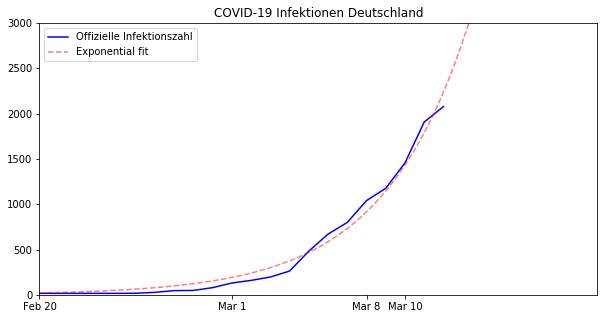

In [23]:
plt.figure(figsize=(10,5))
plt.title("COVID-19 Infektionen Deutschland")
plt.plot(x_data, y_data, color="blue")
plt.plot(X_pred, Y_pred, "--", color="red", alpha=0.5)

plt.xticks([ ts(2020,2,20), ts(2020,3,1), ts(2020,3,8), ts(2020,3,10) ],
           ["Feb 20", "Mar 1", "Mar 8", "Mar 10"])
plt.legend([ "Offizielle Infektionszahl", "Exponential fit" ])
plt.xlim( ts(2020,2,20), ts(2020,3,20) )
plt.ylim( 0, 3000 )

# Kernel Ridge Regression

In [24]:
from sklearn.kernel_ridge import KernelRidge

In [25]:
x0 = ts(2020,2,1)
xn_data = (x_data - x0) / 86400 # in days since 2020-02-01

In [26]:
import math

Score:  0.901660942571


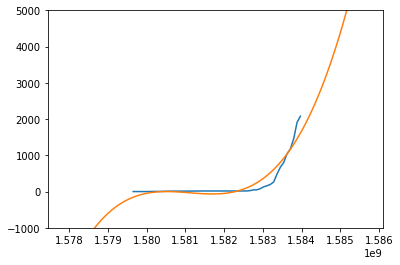

In [27]:
# KR = KernelRidge(alpha=0.1, kernel="linear").fit(xn_data, y_data) # Linear
# KR = KernelRidge(alpha=0.1, kernel="poly", degree=2).fit(xn_data, y_data) # Polynomial
# KR = KernelRidge(alpha=0.1, kernel="rbf").fit(xn_data, y_data) # RBF ??

# def K(x1, x2): return x1*x2 # Linear
def K(x1, x2): return (1+x1*x2)**3/1000 # Poly
# def K(x1, x2): return np.exp(-abs(x1-x2)**2) # Gauss
# def K(x1, x2): return np.exp(-abs(x1-x2))    # Laplace
KR = KernelRidge(alpha=1e+3, kernel=K).fit(xn_data, y_data)

X_pred = np.linspace( ts(2020,1,1), ts(2020, 4, 1), 100 )
Y_pred = KR.predict(np.array([X_pred - x0]).T / 86400)
plt.plot(x_data, y_data)
plt.plot(X_pred, Y_pred)

plt.ylim( -1000, 5000 )
print("Score: ", KR.score(xn_data, y_data))

In [45]:
(np.exp(np.log(Cases).diff()) - 1) * 100

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/algorithms.py:1547: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


1.579651e+09           NaN
1.579738e+09           NaN
1.579824e+09           NaN
1.579910e+09           NaN
1.579997e+09           NaN
1.580083e+09           inf
1.580170e+09    300.000000
1.580256e+09      0.000000
1.580342e+09      0.000000
1.580429e+09     25.000000
1.580515e+09     60.000000
1.580602e+09     25.000000
1.580688e+09     20.000000
1.580774e+09      0.000000
1.580861e+09      0.000000
1.580947e+09      0.000000
1.581034e+09      8.333333
1.581120e+09      0.000000
1.581206e+09      7.692308
1.581293e+09      0.000000
1.581379e+09     14.285714
1.581466e+09      0.000000
1.581552e+09      0.000000
1.581638e+09      0.000000
1.581725e+09      0.000000
1.581811e+09      0.000000
1.581898e+09      0.000000
1.581984e+09      0.000000
1.582070e+09      0.000000
1.582157e+09      0.000000
1.582243e+09      0.000000
1.582330e+09      0.000000
1.582416e+09      0.000000
1.582502e+09      0.000000
1.582589e+09      6.250000
1.582675e+09     58.823529
1.582762e+09     70.370370
1

In [43]:
Cases

1.579651e+09       0
1.579738e+09       0
1.579824e+09       0
1.579910e+09       0
1.579997e+09       0
1.580083e+09       1
1.580170e+09       4
1.580256e+09       4
1.580342e+09       4
1.580429e+09       5
1.580515e+09       8
1.580602e+09      10
1.580688e+09      12
1.580774e+09      12
1.580861e+09      12
1.580947e+09      12
1.581034e+09      13
1.581120e+09      13
1.581206e+09      14
1.581293e+09      14
1.581379e+09      16
1.581466e+09      16
1.581552e+09      16
1.581638e+09      16
1.581725e+09      16
1.581811e+09      16
1.581898e+09      16
1.581984e+09      16
1.582070e+09      16
1.582157e+09      16
1.582243e+09      16
1.582330e+09      16
1.582416e+09      16
1.582502e+09      16
1.582589e+09      17
1.582675e+09      27
1.582762e+09      46
1.582848e+09      48
1.582934e+09      79
1.583021e+09     130
1.583107e+09     159
1.583194e+09     196
1.583280e+09     262
1.583366e+09     482
1.583453e+09     670
1.583539e+09     799
1.583626e+09    1040
1.583712e+09 